In [2]:
import Modules.model.Segment as Segment
import torchvision
import torch
import Modules.model.Detector as Detector
import Modules.model.Classifier as Classifier
import os
import matplotlib.pyplot as plt
from torchvision.transforms._presets import ObjectDetection
from functools import partial
import numpy as np
import os
import json
import PIL.Image as Image
from Modules.dataloader import base_dataset

In [3]:
class PennFudanDataset(base_dataset):

    def __init__(self, transform=None,
                 data_path='../../data/PennFudanPed/'):
        
        
        imgs = list(map(lambda img: os.path.join(data_path, "PNGImages", img), 
                        sorted(os.listdir(os.path.join(data_path, "PNGImages")))))
        masks = list(map(lambda mask: os.path.join(data_path, "PedMasks", mask), 
                        sorted(os.listdir(os.path.join(data_path, "PedMasks")))))
        
        if(transform is None):
            transform = partial(ObjectDetection)()

        super(PennFudanDataset, self).__init__(data=imgs, targets=masks, transform=transform)

    def __parse_mask__(self, mask):
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        return boxes, masks, obj_ids

    def __load_sample__(self, index) -> dict:
        
        img = Image.open(self.data[index]).convert("RGB")
        mask = Image.open(self.targets[index]).convert('L')
        boxes, masks, obj_ids = self.__parse_mask__(mask)

        return {'data': img,
                'target': {'boxes': boxes,
                           'masks': masks,
                           'obj_ids': obj_ids},
                'original': img}
    
    def __transform__(self, sample: dict) -> dict:
        
        boxes = sample['target']['boxes']
        masks = sample['target']['masks']
        num_objs = len(sample['target']['obj_ids'])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        # image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([0])
        target["area"] = area
        target["iscrowd"] = iscrowd

        sample.update({'target': target})

        return super().__transform__(sample)

In [4]:
dataset = PennFudanDataset(data_path='data\PennFudanPed', 
                           transform=None)

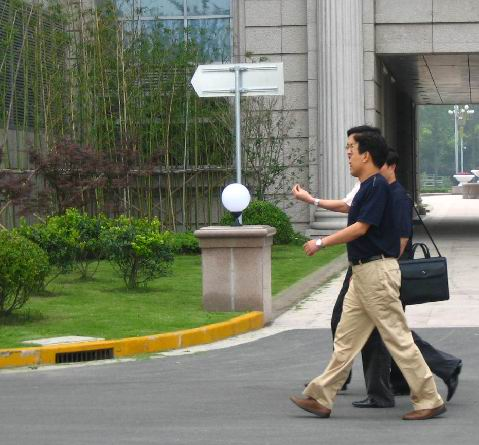

In [7]:
dataset[2]['original']